In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df1 = pd.read_csv('/home/sasidharreddy/study/OELP_sem6/new_code/data.csv')
df=df1[['idates','imonths','iyears','obs']]
df.to_csv('new_output_file.csv', index=False)
df['datetime'] = pd.to_datetime( df['idates'].astype(str)+ '-' + df['imonths'].astype(str)+'-'+df['iyears'].astype(str))
df = df.drop(['idates', 'imonths', 'iyears'], axis=1)
df.to_csv('output_file.csv', index=False)

df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

/tmp/ipykernel_8652/2716774584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime( df['idates'].astype(str)+ '-' + df['imonths'].astype(str)+'-'+df['iyears'].astype(str))


In [4]:
df.head()

,obs
datetime,
2007-01-01,0.0
2007-02-01,0.0
2007-03-01,0.0
2007-04-01,0.0
2007-05-01,0.0


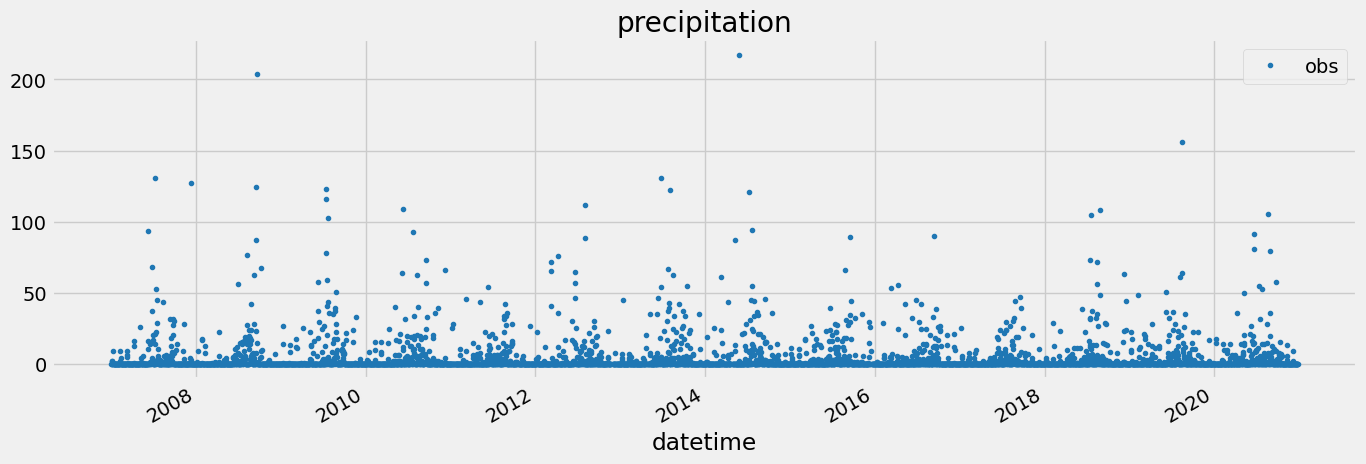

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation')
plt.show()

<AxesSubplot:ylabel='Frequency'>

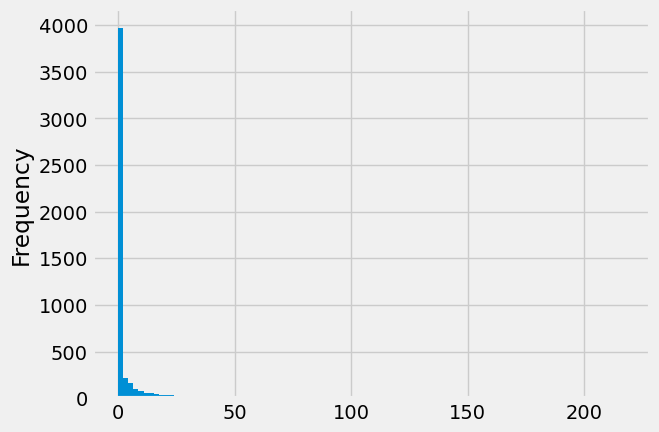

In [5]:
df['obs'].plot(kind='hist', bins=100)

<AxesSubplot:xlabel='datetime'>

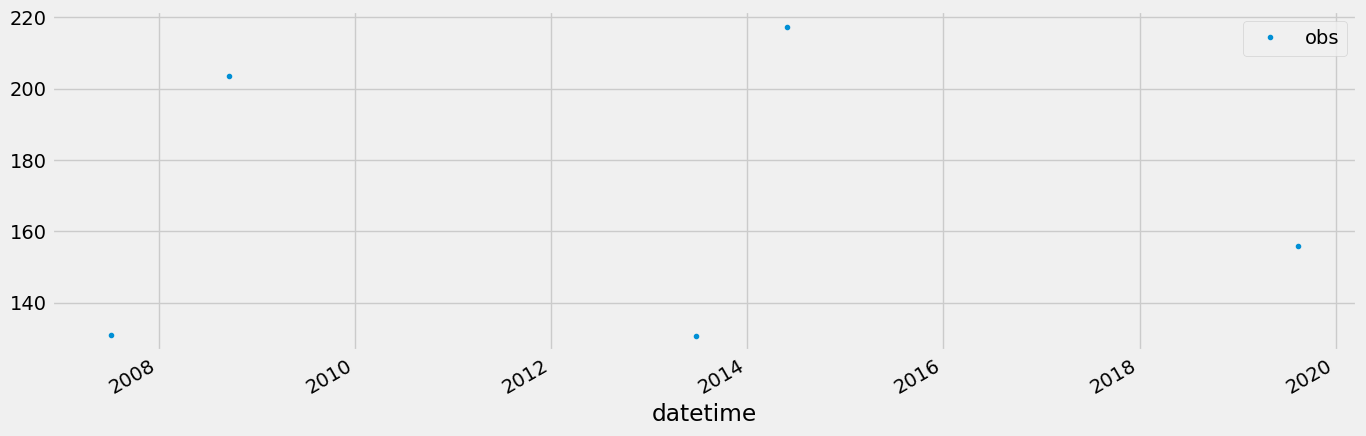

In [6]:
df.query('obs>130').plot(figsize=(15,5),style=".")

In [7]:
df = df.query('obs<130').copy()

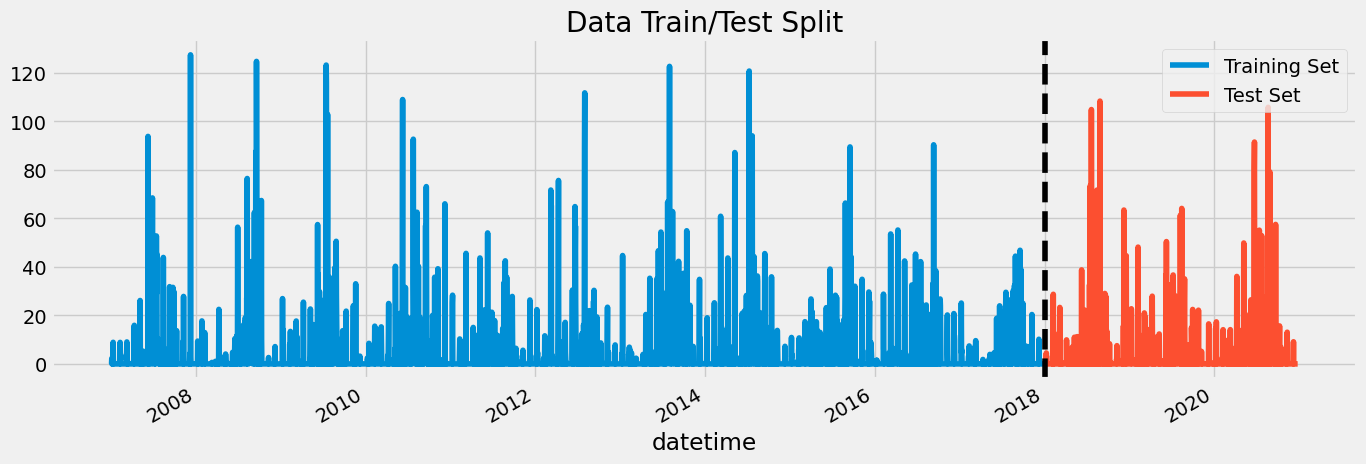

In [8]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [9]:
from sklearn.model_selection import TimeSeriesSplit
#test size 1 day*365 days*1 year
tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
df = df.sort_index()

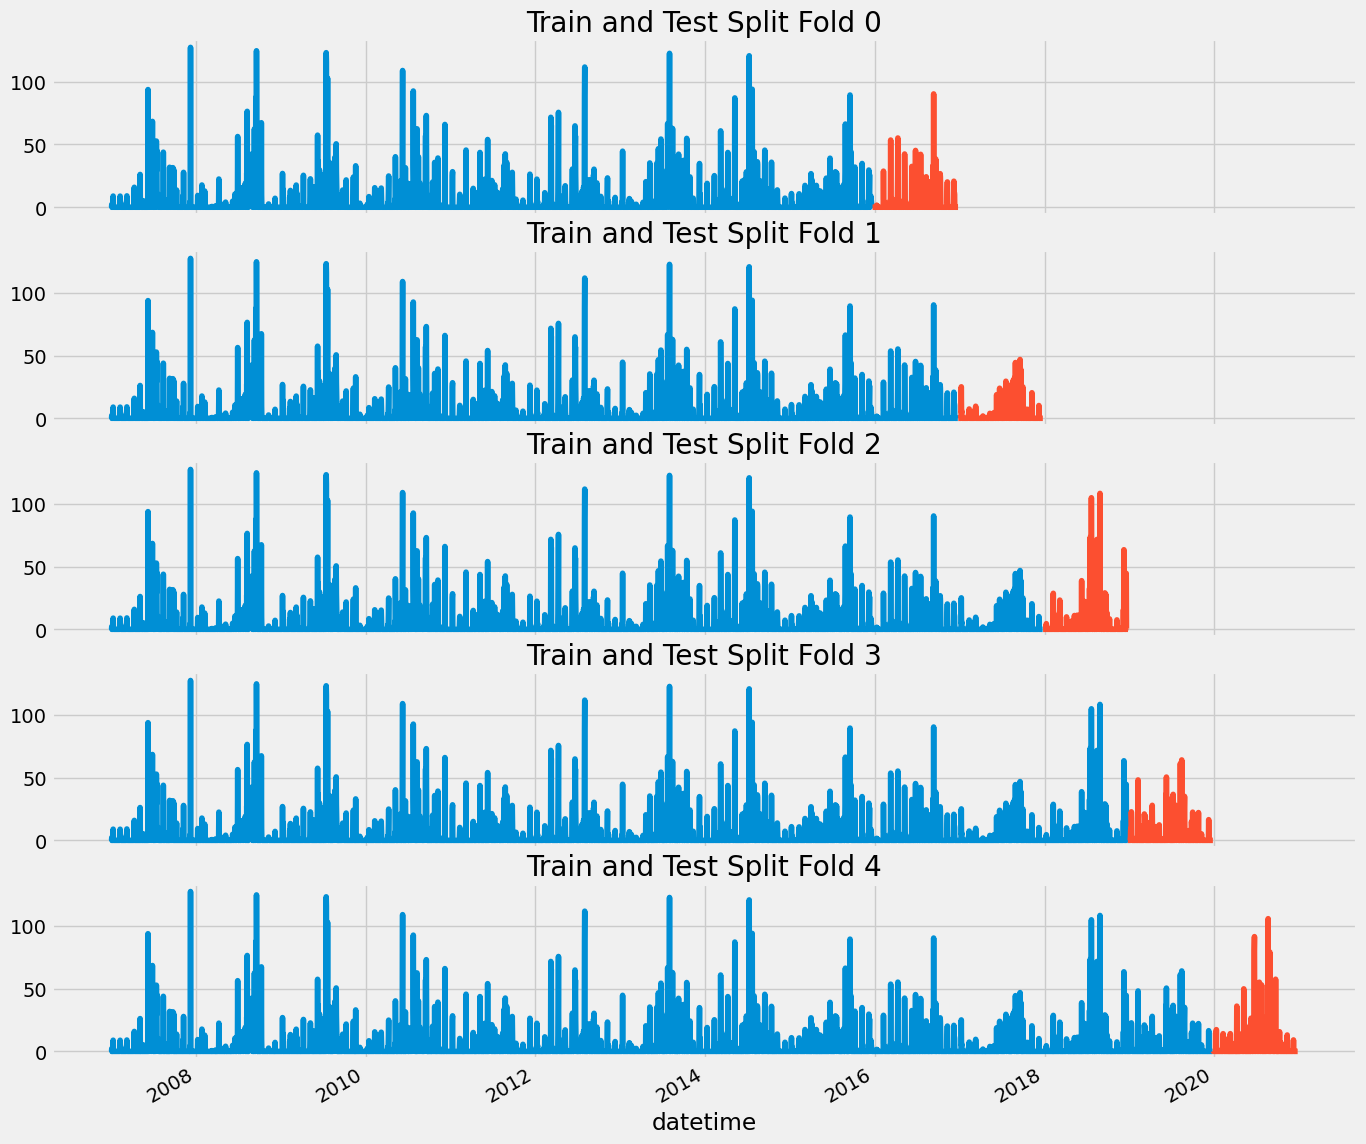

In [10]:
#time series cross validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['obs'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train and Test Split Fold {fold}')
    test['obs'].plot(ax=axs[fold],
                         label='Test Set')
    #axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [12]:
def add_lags(df):
    target_map = df['obs'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [13]:
df = add_lags(df)

In [14]:
df.head()

,obs,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
datetime,,,,,,,,,,,
2007-01-01,0.00,0,1,1,2007,1,1,1,NaN,NaN,NaN
2007-01-02,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN
2007-01-03,2.27,2,1,1,2007,3,3,1,NaN,NaN,NaN
2007-01-04,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN
2007-01-05,1.75,4,1,1,2007,5,5,1,NaN,NaN,NaN


In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'obs'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.04)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:12.10835	validation_1-rmse:9.65746


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[92]	validation_0-rmse:10.50967	validation_1-rmse:9.21436
[0]	validation_0-rmse:11.88175	validation_1-rmse:6.70360
[98]	validation_0-rmse:10.39391	validation_1-rmse:6.05937


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:11.49707	validation_1-rmse:12.83425


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:10.05392	validation_1-rmse:11.69629
[200]	validation_0-rmse:9.60002	validation_1-rmse:11.57290
[245]	validation_0-rmse:9.40654	validation_1-rmse:11.60463
[0]	validation_0-rmse:11.61441	validation_1-rmse:8.82468
[100]	validation_0-rmse:10.16764	validation_1-rmse:8.13052
[120]	validation_0-rmse:10.07454	validation_1-rmse:8.17885


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:11.42033	validation_1-rmse:12.35590
[100]	validation_0-rmse:10.06053	validation_1-rmse:11.39354


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.69920	validation_1-rmse:11.36567
[212]	validation_0-rmse:9.66684	validation_1-rmse:11.35717


In [16]:
scores

[9.171593308098439,
 6.012316444162499,
 11.563219044358995,
 8.06448221232038,
 11.354469214250702]

In [17]:
print(f'mean square error across folds {np.mean(scores):0.4f}')
print(f'Fold mean square error:{scores}')

mean square error across folds 9.2332
Fold mean square error:[9.171593308098439, 6.012316444162499, 11.563219044358995, 8.06448221232038, 11.354469214250702]


In [18]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'obs'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.04)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:11.34186


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:9.11609
[200]	validation_0-rmse:8.34650
[300]	validation_0-rmse:7.69024
[400]	validation_0-rmse:7.08600
[500]	validation_0-rmse:6.47088
[600]	validation_0-rmse:6.05930
[700]	validation_0-rmse:5.71675
[800]	validation_0-rmse:5.45566
[900]	validation_0-rmse:5.20210
[999]	validation_0-rmse:4.95751


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the entire dataset
y_pred_all = reg.predict(X_all)

# Calculate RMSE
rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all))
print("RMSE of retrained data:", rmse_all)


RMSE of retrained data: 4.957514768586776


In [20]:
df.index.max()

Timestamp('2020-12-25 00:00:00')

In [21]:
# Create future dataframe
future = pd.date_range('2020-12-25','2020-12-27')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = True
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [22]:
df_and_future

,obs,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2007-01-01,0.00,0,1,1,2007,1,1,1,NaN,NaN,NaN,True
2007-01-02,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN,True
2007-01-03,2.27,2,1,1,2007,3,3,1,NaN,NaN,NaN,True
2007-01-04,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN,True
2007-01-05,1.75,4,1,1,2007,5,5,1,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.00,3,4,12,2020,359,24,52,0.00,0.0,0.0,True
2020-12-25,0.00,4,4,12,2020,360,25,52,0.35,0.0,0.0,True
2020-12-25,NaN,4,4,12,2020,360,25,52,0.35,0.0,0.0,True
2020-12-26,NaN,5,4,12,2020,361,26,52,0.00,0.0,0.0,True


In [23]:
future_w_features = df_and_future.query('isFuture').copy()

In [24]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'] = future_w_features['pred'].clip(lower=0)

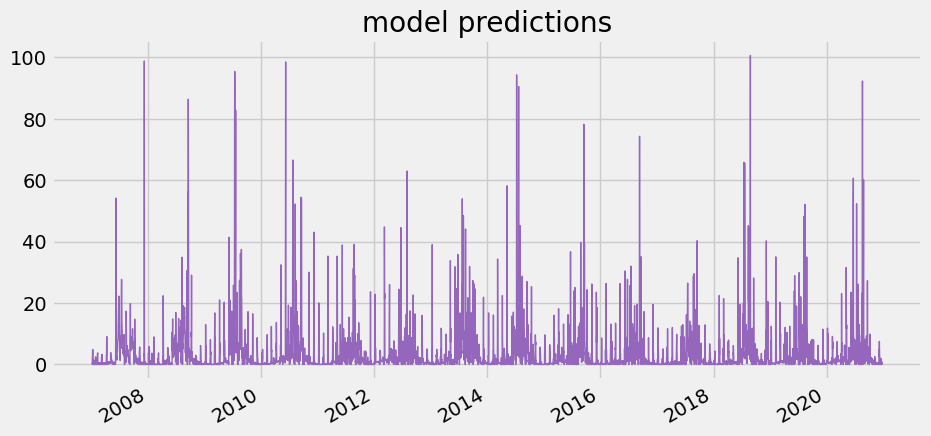

In [25]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='model predictions')
plt.show()

<AxesSubplot:xlabel='datetime'>

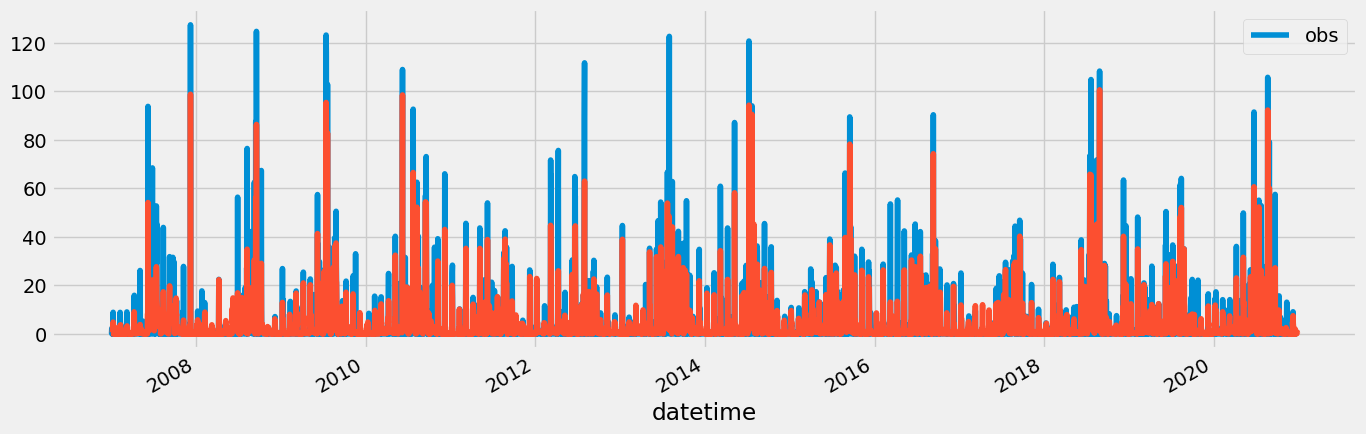

In [26]:
ax = df[['obs']].plot(figsize=(15, 5))
future_w_features['pred'].plot(ax=ax)

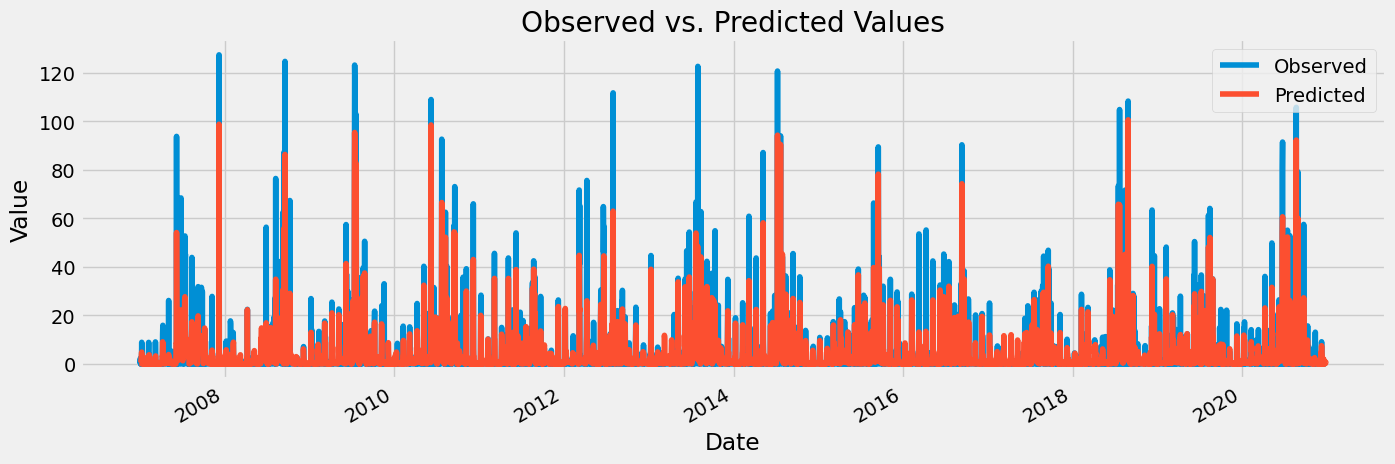

In [27]:
import matplotlib.pyplot as plt

# Plot observed values
ax = df[['obs']].plot(figsize=(15, 5))

# Plot predicted values
future_w_features['pred'].plot(ax=ax)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Observed vs. Predicted Values')

# Show legend
plt.legend(['Observed', 'Predicted'])

# Show plot
plt.show()


In [28]:
future_w_features['pred']

2007-01-01    0.137924
2007-01-02    0.121211
2007-01-03    0.198278
2007-01-04    0.207511
2007-01-05    0.512196
                ...   
2020-12-24    0.256368
2020-12-25    0.782259
2020-12-25    0.782259
2020-12-26    0.076322
2020-12-27    0.000000
Name: pred, Length: 4993, dtype: float32

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error
future_w_features_clean = future_w_features.dropna(subset=['obs', 'pred'])

# Calculate RMSE score
score = np.sqrt(mean_squared_error(future_w_features_clean['obs'], future_w_features_clean['pred']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 4.95


In [30]:
df1['stdmod']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4990    0.0
4991    0.0
4992    0.0
4993    0.0
4994    0.0
Name: stdmod, Length: 4995, dtype: float64

future

In [31]:
# Create future dataframe
future = pd.date_range('2020-12-25','2021-12-25')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] =False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [32]:
df_and_future


,obs,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2007-01-01,0.00,0,1,1,2007,1,1,1,NaN,NaN,NaN,False
2007-01-02,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN,False
2007-01-03,2.27,2,1,1,2007,3,3,1,NaN,NaN,NaN,False
2007-01-04,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN,False
2007-01-05,1.75,4,1,1,2007,5,5,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-21,NaN,1,4,12,2021,355,21,51,0.0,0.00,0.0,True
2021-12-22,NaN,2,4,12,2021,356,22,51,0.0,0.00,0.0,True
2021-12-23,NaN,3,4,12,2021,357,23,51,0.0,0.00,0.0,True
2021-12-24,NaN,4,4,12,2021,358,24,51,NaN,0.35,0.0,True


In [33]:
future_w_features = df_and_future.query('isFuture').copy()

In [34]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'] = future_w_features['pred'].clip(lower=0)

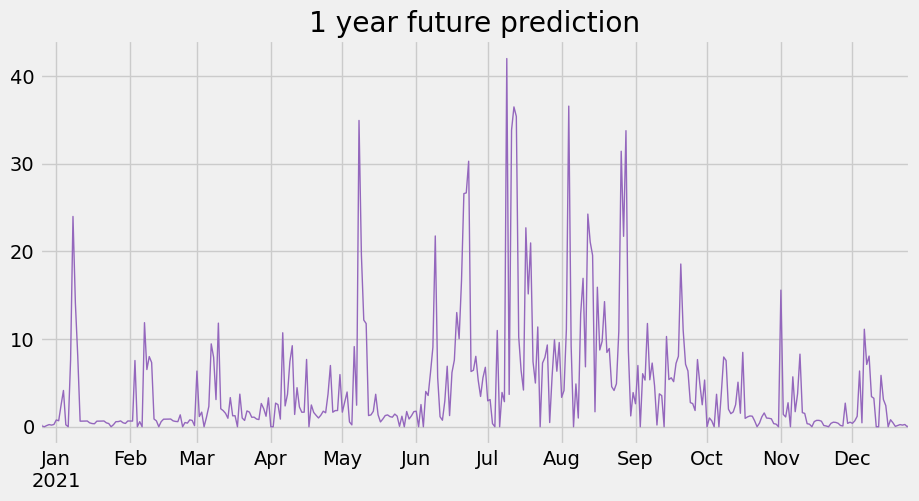

In [35]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='1 year future prediction')
plt.show()

In [36]:
# Make predictions on the entire dataset
y_pred_all = reg.predict(X_all)

# Calculate mean and standard deviation of predictions
modmean = np.mean(y_pred_all)
modstd = np.std(y_pred_all)

print("Mean of predictions:", modmean)
print("Standard deviation of predictions:", modstd)


Mean of predictions: 3.5178404
Standard deviation of predictions: 7.8750095
